# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

from utils import extract_time
from utils import random_generator
from utils import MinMaxScaler
from utils import sine_data_generation
from utils import visualization

from modules_and_training import TimeGAN
from modules_and_training import Time_GAN_module

# Parameters

In [2]:
def Normalize(dta):
  return (dta - np.min(dta, 0)) /  (np.max(dta, 0) - np.min(dta, 0) + 1e-7)

In [3]:
def real_data_loading (path, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  assert os.path.isfile(path)
  ori_data = np.loadtxt(path, delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = Normalize(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    # yields an array of dims [len(dta) - seq_len, seq_len, n_variables]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
    
  return data

In [4]:
file = 'stock_data.csv'
seq_len = 24
data = real_data_loading(file, seq_len)

In [5]:
#output_size = 20
gamma = 1
no, seq_len, dim = len(data), 24, 6

parameters = dict()
parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layers'] = 3
parameters['iterations'] = 10
parameters['batch_size'] = 128
parameters['epoch'] = 10

In [6]:
Generator, Embedder, Supervisor, Recovery, Discriminator, checkpoints = TimeGAN(data, parameters)

Start Embedding Network Training


RuntimeError: Found dtype Double but expected Float

A Data Set of the same size and dimensions of the original synthetic data Set is generated and visualized and both are compared

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000495
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.638962
[t-SNE] KL divergence after 300 iterations: 1.430081


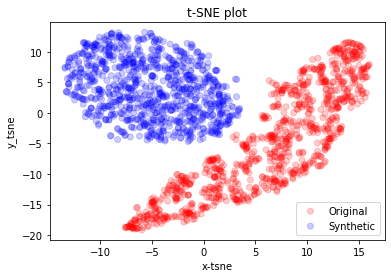

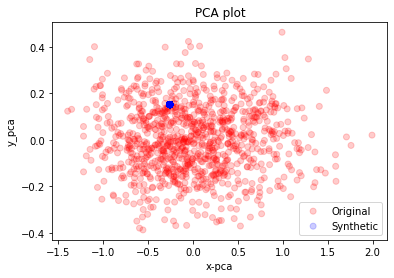

In [10]:
random_test = random_generator(no, dim, extract_time(data)[0], extract_time(data)[1])
test_sample = Generator(torch.tensor(random_generator(no, dim, extract_time(data)[0], extract_time(data)[1])).float())[0]
test_sample = torch.reshape(test_sample, (no, seq_len, parameters['hidden_dim']))
test_recovery = Recovery(test_sample)
test_recovery = torch.reshape(test_recovery[0], (no, seq_len, dim))
visualization(data, test_recovery.detach().numpy(), 'tsne')
visualization(data, test_recovery.detach().numpy(), 'pca')
  